# Optimization with bathymetry and max water depth constraint

[Try this yourself](https://colab.research.google.com/github/DTUWindEnergy/TopFarm2/blob/master/docs/notebooks/bathymetry.ipynb) (requires google account)


In this example, an optimization is made where the bathymetry of a site is considered. In addition, a constraint on the allowable maximum water depth is specified.

**Install TOPFARM if needed**

In [ ]:
# Install TopFarm if needed
import importlib
if not importlib.util.find_spec("topfarm"):
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git

**Install packages if running in Colab**

In [ ]:
try:
    RunningInCOLAB = 'google.colab' in str(get_ipython())
except NameError:
    RunningInCOLAB = False

In [ ]:
%%capture
if RunningInCOLAB:
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git
  !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/TopFarm2.git
  !pip install scipy==1.6.3 #  constraint is not continuous which trips vers. 1.4.1 which presently is the default version
  import os
  os.kill(os.getpid(), 9)

**First we import basic Python elements and some TOPFARM classes**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

from topfarm.cost_models.cost_model_wrappers import CostModelComponent
from topfarm.easy_drivers import EasyScipyOptimizeDriver
from topfarm import TopFarmProblem
from topfarm.plotting import NoPlot, XYPlotComp
from topfarm.constraint_components.boundary import XYBoundaryConstraint
from topfarm.constraint_components.spacing import SpacingConstraint
from topfarm.examples.data.parque_ficticio_offshore import ParqueFicticioOffshore

from py_wake.deficit_models.gaussian import IEA37SimpleBastankhahGaussian
from py_wake.examples.data.iea37._iea37 import IEA37_WindTurbines

**Now, we set up the site and optimization problem**.

In this case, we are using the `ParqueFicticioOffshore` [site](https://topfarm.pages.windenergy.dtu.dk/PyWake/notebooks/Site.html), which is defined in PyWake. The cost function must also calculate the water depth in addition to the AEP, as it will be used as **post_constraints** in the optimization problem.

In [ ]:
#setting up the site and the initial position of turbines
site = ParqueFicticioOffshore()
site.bounds = 'ignore'
x_init, y_init = site.initial_position[:,0], site.initial_position[:,1]
boundary = site.boundary

#Wind turbines and wind farm model definition
windTurbines = IEA37_WindTurbines() 
wfm = IEA37SimpleBastankhahGaussian(site, windTurbines)

#parameters for the AEP calculation 
wsp = np.asarray([10, 15])
wdir = np.arange(0,360,45)
maximum_water_depth = -52   #[m]
n_wt = x_init.size

def aep_func(x, y, **kwargs):
    simres = wfm(x, y, wd=wdir, ws=wsp)
    aep = simres.aep().values.sum()
    water_depth = np.diag(wfm.site.ds.interp(x=x, y=y)['water_depth'])
    return [aep, water_depth]

#parameters for the optimization problem
tol = 1e-8
ec = 1e-2
min_spacing = 260
maxiter = 30

#Cost model component and Topfarm problem
cost_comp = CostModelComponent(input_keys=[('x', x_init),('y', y_init)],
                                          n_wt=n_wt,
                                          cost_function=aep_func,
                                          objective=True,
                                          maximize=True,
                                          output_keys=[('AEP', 0), ('water_depth', np.zeros(n_wt))]
                                          )

problem = TopFarmProblem(design_vars={'x': x_init, 'y': y_init},
                         constraints=[XYBoundaryConstraint(boundary),
                                      SpacingConstraint(min_spacing)],
                          post_constraints=[('water_depth', {'lower': maximum_water_depth})],
                          n_wt = n_wt,
                          cost_comp=cost_comp,
                          driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
                          plot_comp=XYPlotComp(),
                          expected_cost=ec)

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


**Now we run the optimization**

INFO: checking out_of_order
INFO: checking system
INFO: checking solvers
INFO: checking dup_inputs
INFO: checking missing_recorders
INFO: checking unserializable_options
INFO: checking comp_has_no_outputs
INFO: checking auto_ivc_warnings


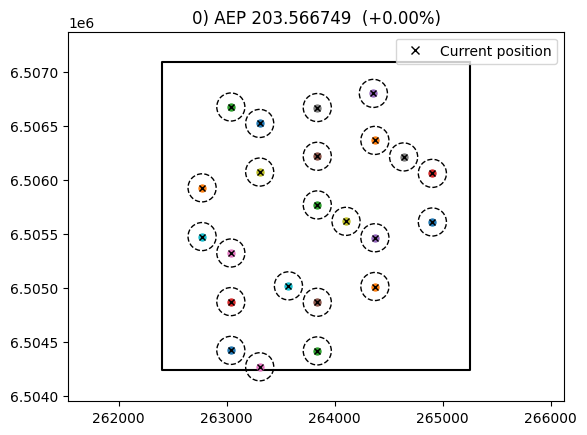

Iteration limit reached    (Exit mode 9)
            Current function value: -22373.521516113207
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization took: 42s


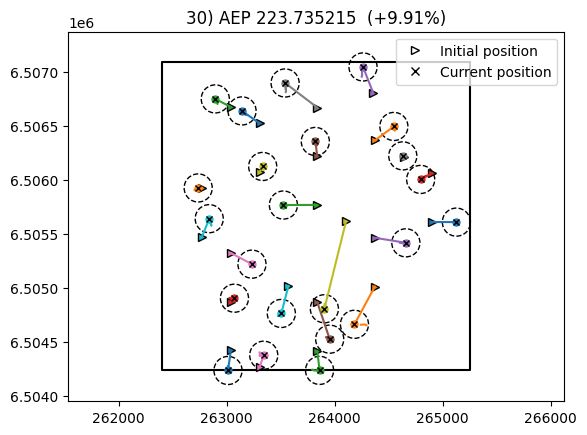

In [ ]:
tic = time.time()

cost, state, recorder = problem.optimize()
toc = time.time()
print('Optimization took: {:.0f}s'.format(toc-tic))

We can use the recorder to plot the evolution of the water depth with each iteration.

Text(0, 0.5, 'Max depth [m]')

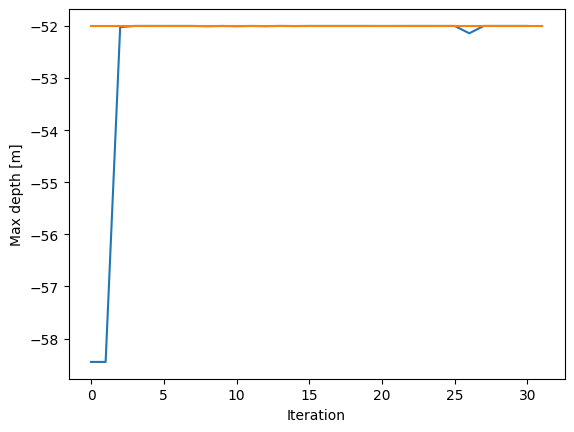

In [ ]:
plt.plot(recorder['water_depth'].min((1)))
plt.plot([0,recorder['water_depth'].shape[0]],[maximum_water_depth, maximum_water_depth])
plt.xlabel('Iteration')
plt.ylabel('Max depth [m]')

We can also visualize the initial vs optimized layout as countour plots that show the water depth. Note how it is clear how the optimized positions do not cross the boundary set for the water depth.

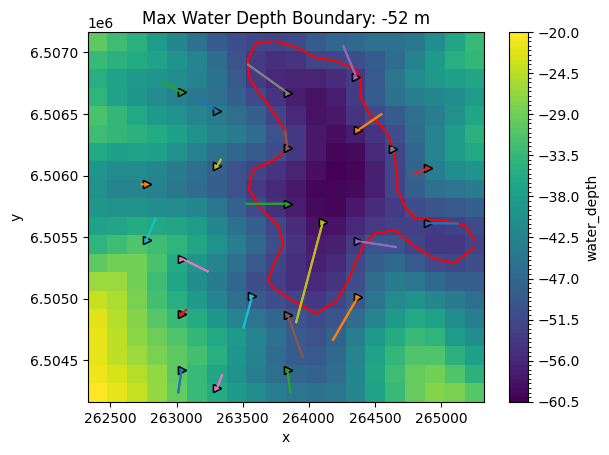

In [ ]:
values = site.ds.water_depth.values
x = site.ds.x.values
y = site.ds.y.values
levels = np.arange(int(values.min()), int(values.max()))
max_wd_index = int(np.argwhere(levels==maximum_water_depth))
Y, X = np.meshgrid(y, x)
cs = plt.contour(x, y , values.T, levels)
plt.close()
lines = []

for line in cs.collections[max_wd_index].get_paths():
     lines.append(line.vertices)
fig2, ax2 = plt.subplots(1)

site.ds.water_depth.plot(ax=ax2, levels=100)
for line in lines:
    ax2.plot(line[:, 0], line[:,1], 'r')
    problem.model.plot_comp.plot_initial2current(x_init, y_init, state['x'], state['y'])
    ax2.set_title(f'Max Water Depth Boundary: {maximum_water_depth} m')